In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import autoencoder.helpers as helpers
from autoencoder.neuralnet import NeuralNetwork
from autoencoder.layers import (
  LinearLayer,
  SigmoidLayer,
  TanhLayer,
  ReluLayer,
  MSEOutputLayer
)

import tikhonov
from utils import avgn_attack
from utils import ssim

In [2]:
shape=(28, 28)

In [3]:
def compare_denoised_images(images_true, images_noisy, denoised_samples, num_samples=8, idx=0, shape=(28, 28)):
  images_true_ = images_true[idx:idx+num_samples]
  images_noisy_ = images_noisy[idx:idx+num_samples]
  denoised_samples_ =  denoised_samples[idx:idx+num_samples]
  fig, axs = plt.subplots(3, num_samples, figsize=(30, 10))
  axs_ = axs.ravel()

  for i, (ts, ns, ds) in enumerate(zip(images_true_, images_noisy_, denoised_samples_)):
    axs_[i].axis('off')
    axs_[i].imshow(ts.reshape(shape), cmap="gray")
    axs_[(num_samples) + i].imshow(ns.reshape(shape), cmap="gray")
    axs_[(2 * num_samples) + i].imshow(ds.reshape(shape), cmap="gray")

In [4]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train.reshape(-1, 28*28) / 255
X_test = X_test.reshape(-1, 28*28) / 255

In [5]:
X_train_noisy = np.array([avgn_attack(x, 0.75, 0) for x in X_train])
X_test_noisy = np.array([avgn_attack(x, 0.75, 0) for x in X_test])

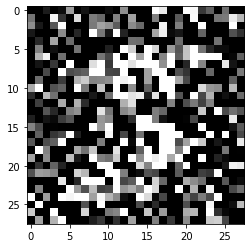

In [6]:
plt.imshow(X_train_noisy[0].reshape(28, 28), 'gray')

In [7]:
# Number of neurons in the first hidden-layer
hidden_neurons_1 = 64

# Number of neurons in the second hidden-layer
hidden_neurons_2 = 32

hidden_neurons_3 = 32

# latent_neurons = 32

# Define a list of layers
net_layers = []

net_layers.append(LinearLayer(X_train.shape[1], hidden_neurons_1))
net_layers.append(ReluLayer())

net_layers.append(LinearLayer(hidden_neurons_1, hidden_neurons_2))
net_layers.append(ReluLayer())

# net_layers.append(LinearLayer(hidden_neurons_2, hidden_neurons_3))
# net_layers.append(ReluLayer())

# net_layers.append(LinearLayer(hidden_neurons_2, hidden_neurons_3))
# net_layers.append(TanhLayer())

# net_layers.append(LinearLayer(hidden_neurons_3, hidden_neurons_2))
# net_layers.append(TanhLayer())

#net_layers.append(LinearLayer(hidden_neurons_2, hidden_neurons_1))
#net_layers.append(ReluLayer())

net_layers.append(LinearLayer(hidden_neurons_2, X_train.shape[1]))
net_layers.append(SigmoidLayer())

#net_layers.append(SoftmaxOutputLayer())
net_layers.append(MSEOutputLayer())

net = NeuralNetwork()

# Tahh -> Sigmoid ~100

net.fit(X_train_noisy, X_train, X_test_noisy, X_test, net_layers, 
        max_iterations=35, batch_size=128, learning_rate=0.015, output_each_iter=1)

Iteration: 0; Train loss: 0.18966676193272491; Validation loss: 0.18981439277707496;
Iteration: 1; Train loss: 0.18972682248609649; Validation loss: 0.18974165150335756;
Iteration: 2; Train loss: 0.1896413150512424; Validation loss: 0.1896562822527;
Iteration: 3; Train loss: 0.18952901471880815; Validation loss: 0.18951611213407257;
Iteration: 4; Train loss: 0.18904551956042367; Validation loss: 0.1890199972537085;
Iteration: 5; Train loss: 0.18863387999687148; Validation loss: 0.1886047546316492;
Iteration: 6; Train loss: 0.18829884127029975; Validation loss: 0.18827160899655054;
Iteration: 7; Train loss: 0.18806427936552486; Validation loss: 0.1880318948995672;
Iteration: 8; Train loss: 0.18789185708606645; Validation loss: 0.18785632775470457;
Iteration: 9; Train loss: 0.18774047791292098; Validation loss: 0.18770524674983866;
Iteration: 10; Train loss: 0.18761460008296943; Validation loss: 0.18757927204926525;
Iteration: 11; Train loss: 0.18748658234245935; Validation loss: 0.18745

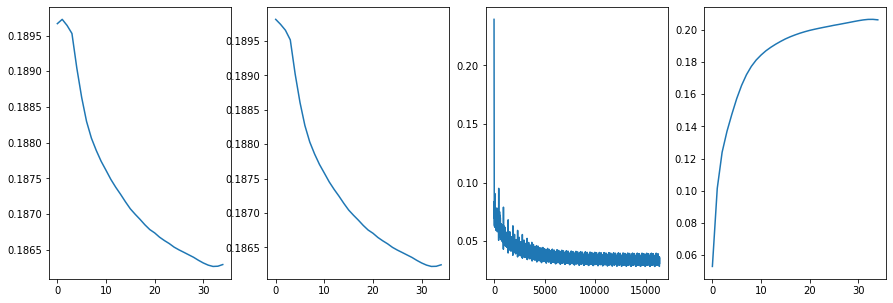

In [8]:
fig, axs_costs = plt.subplots(1, 4, figsize=(15, 5))
axs_costs_ = axs_costs.ravel()
for i, costs in enumerate(
  [net.train_costs, net.val_costs, net.batch_costs, net.ssim_costs]):
  axs_costs_[i].plot(costs)

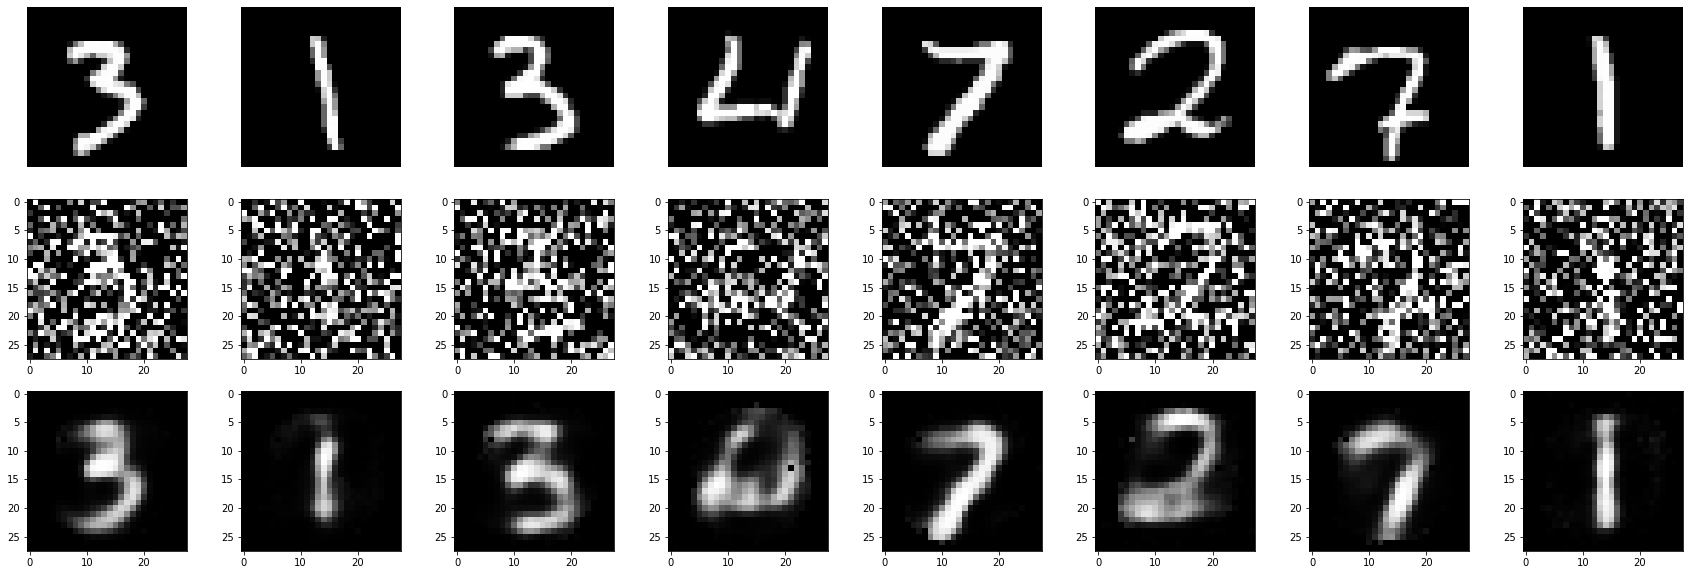

In [9]:
X_test_denoised_autoencoder = net.forward_step(X_test_noisy)[-1]
compare_denoised_images(X_test, X_test_noisy, X_test_denoised_autoencoder, idx=30)

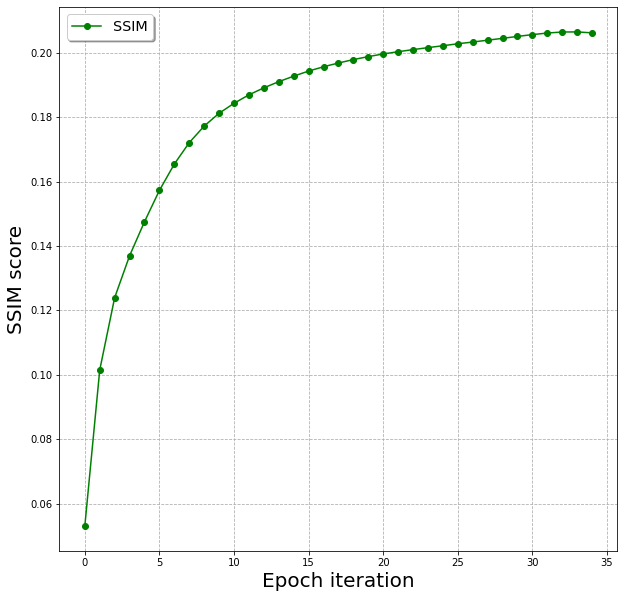

In [25]:
"""
[0.08796975330682472, 0.16110488993488253, 0.19499662654288114, 0.21184221137687564, 0.2271088240072131, 0.24005389137566088, 0.25066351728141306, 0.25958357924222947, 0.26742243687808515, 0.2751030956953764, 0.2824278920143843, 0.2889249113574624, 0.2944175705835223, 0.29872014674544334, 0.3022242000848055, 0.30530017347633837, 0.3081676989644766, 0.3110213182941079, 0.3137230723127723, 0.3163199815154076, 0.3189624789506197, 0.3215894022732973, 0.3240816998630762, 0.3263583050444722, 0.3282782381623983, 0.3300696391314268, 0.3316933545097709, 0.3332481457144022, 0.3347417757064104, 0.33591546276956796]]
"""
#indecies = np.arange(0, len(net.ssim_costs)-1, 3).tolist()
#costs = np.array(net.ssim_costs)[indecies]

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel('Epoch iteration', fontsize=20)
ax.set_ylabel('SSIM score', fontsize=20)
plt.grid(linestyle='--')


plt.plot(net.ssim_costs, "go-", label='SSIM')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
fig.savefig("training-ssim.pdf")

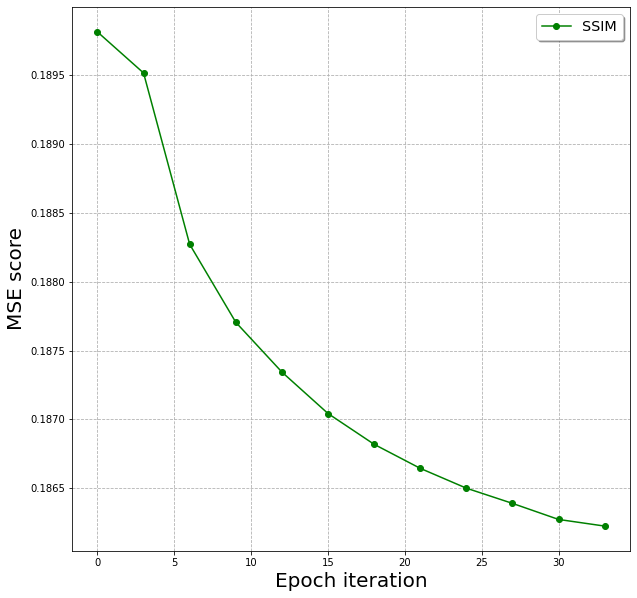

In [11]:
"""
[0.12831482432154193, 0.126240757987006, 0.12450315573643643, 0.12348159149266774, 0.12247684903903182, 0.12165188051810928, 0.12089223815858824, 0.12029861078602709, 0.11979477504238446, 0.1193165323235328, 0.1188621116171617, 0.11847048050350964, 0.11816420827665707, 0.11791130814766183, 0.11768721189304704, 0.11746880801063622, 0.11726081182734108, 0.11704540420684759, 0.11683771806818084, 0.11663801546512795, 0.11644320224931556, 0.11626320524015603, 0.1160999364894973, 0.1159667496161961, 0.11586285096179647, 0.11577296145565284, 0.11569176091782649, 0.11562160879286928, 0.11556917920009573, 0.11551754115893434]
"""
indecies = np.arange(0, len(net.val_costs) - 1, 3).tolist()
costs = np.array(net.val_costs)[indecies]

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel('Epoch iteration', fontsize=20)
ax.set_ylabel('MSE score', fontsize=20)
plt.grid(linestyle='--')
plt.plot(indecies, costs, "go-", label='SSIM')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
fig.savefig("training-mse.pdf")

In [12]:
prefix = "denoising-awgn-05-30-iter-128-batch"
#best - prefix = "denoising-avgn-05-relu-relu-sigmoid-30-iter-128-batch"

In [13]:
# helpers.save_model(net_layers, prefix=prefix)

In [14]:
new_layers = helpers.load_model(prefix)

In [15]:
new_net = NeuralNetwork()
new_net.load_layers(new_layers)

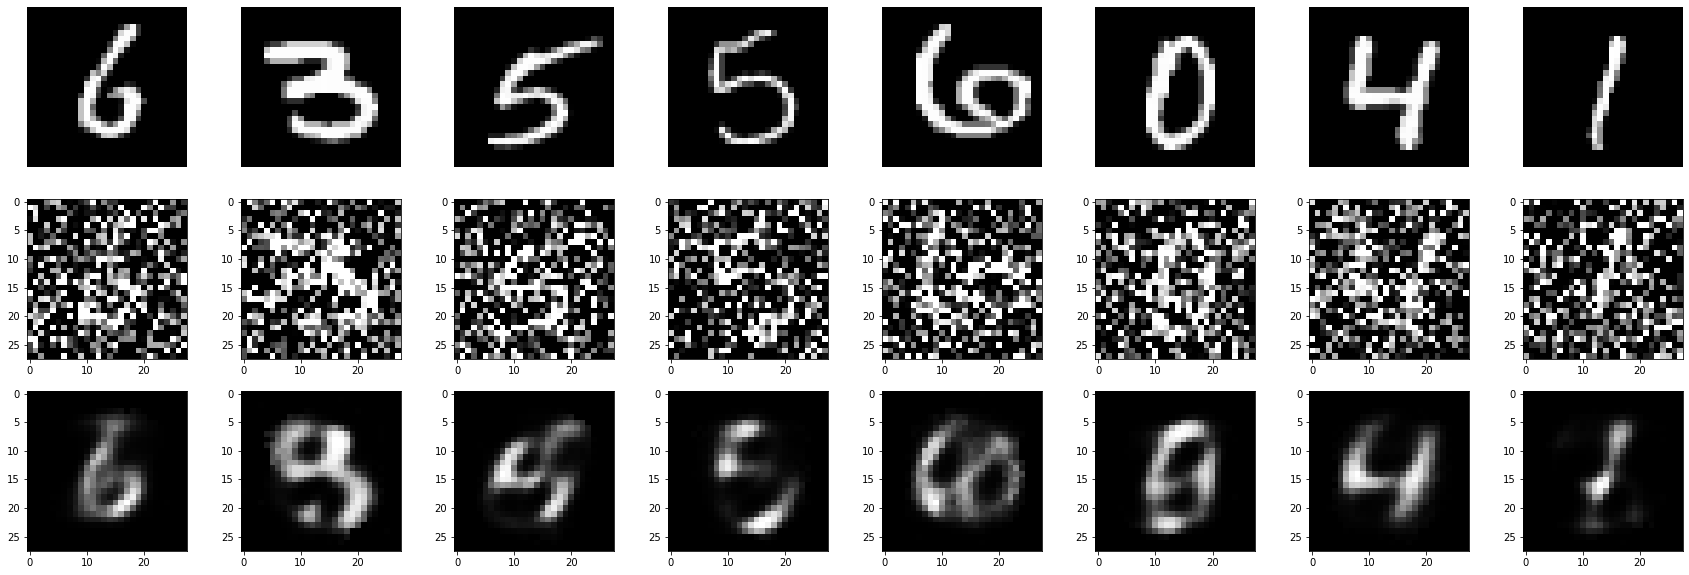

In [16]:
X_test_denoised_autoencoder = new_net.forward_step(X_test_noisy)[-1]
compare_denoised_images(X_test, X_test_noisy, X_test_denoised_autoencoder, idx=50)

### 